In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from statsmodels.regression.rolling import RollingOLS

# Data

In [2]:
his_members = pd.read_excel("../data/members.xlsx", sheet_name=1)
his_members.head()

,1980-03-31,1980-06-30,1980-09-30,1980-12-31,1981-03-31,1981-06-30,1981-09-30,1981-12-31,1982-03-31,1982-06-30,...,2020-09-30,2020-12-31,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-10-20
0,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,...,1981718D UW Equity,2061517D UW Equity,2061517D UW Equity,2150994D UW Equity,2150994D UW Equity,1950546D US Equity,2150994D UW Equity,2150994D UW Equity,A UN Equity,A UN Equity
1,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,...,2061517D UW Equity,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,AA UN Equity,AA UN Equity
2,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,...,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990253D UN Equity,9990213D UN Equity,9990253D UN Equity,A UN Equity,AAL UW Equity,AAL UW Equity
3,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,...,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990527D UW Equity,9990527D UW Equity,9990253D UN Equity,9990527D UW Equity,AA UN Equity,AAP UN Equity,AAP UN Equity
4,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,...,9990213D UN Equity,9990253D UN Equity,9990620D UN Equity,A UN Equity,A UN Equity,9990527D UW Equity,A UN Equity,AAL UW Equity,ACGL UW Equity,ACGL UW Equity


In [87]:
ave_ecoc = pd.read_excel("../clean_data/ave_ecoc_1117.xlsx", index_col=0)
FCFROIC_ADJ = pd.read_excel("../clean_data/FCFROIC_ADJ_1118.xlsx", index_col=0)
ave_ecoc.head()

,beta,name,DATES,GT10 Govt,rf,coe,10y_avg
183,1.138810,A,1994-06-30,7.319975,0.073200,0.141528,0.180326
184,1.133677,A,1994-07-29,7.110731,0.071107,0.139128,0.179694
185,1.110756,A,1994-08-31,7.173438,0.071734,0.138380,0.179047
186,1.106904,A,1994-09-30,7.603406,0.076034,0.142448,0.178495
187,1.110309,A,1994-10-31,7.806800,0.078068,0.144687,0.177961


In [93]:
ave_ecoc.index = ave_ecoc["DATES"]

In [92]:
FCFROIC_ADJ.head()

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_,FCFROIC_ADJ,avg_fcfroic,avg_fcfroic1,avg_fcfroic_expanding
0,1045,1963-06-30,1963,2.0,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1045,1963-09-30,1963,3.0,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1045,1963-12-31,1963,4.0,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1045,1964-03-31,1964,1.0,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1045,1964-06-30,1964,2.0,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
close_price = pd.read_excel("../data/stock_returns.xlsx")
close_price.head()

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return
0,ACF,1961-01-31,50.250,1961-01-31,38.000,0.322368
1,ACF,1961-02-28,50.375,1961-02-28,50.250,0.014743
2,ACF,1961-03-30,54.750,1961-03-30,50.375,0.086849
3,ACF,1961-04-28,56.000,1961-04-28,54.750,0.022831
4,ACF,1961-05-31,59.750,1961-05-31,56.000,0.078315


In [94]:
close_price["q_pre_p"] = close_price["Monthly Price"].shift(3)
close_price["q_ret"] = close_price["Monthly Price"] / \
    close_price["q_pre_p"] - 1

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [121]:
close_price

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return,q_pre_p,q_ret,1y_rollingret,3y_rollingret,5y_rollingret
8114,A,1961-01-31,49.125,1961-01-31,43.500,0.129310,NaN,NaN,NaN,NaN,NaN
8115,A,1961-02-28,54.125,1961-02-28,49.125,0.101781,NaN,NaN,NaN,NaN,NaN
8116,A,1961-03-30,54.000,1961-03-30,54.125,0.007103,NaN,NaN,NaN,NaN,NaN
8117,A,1961-04-28,60.625,1961-04-28,54.000,0.122685,49.125,0.234097,NaN,NaN,NaN
8118,A,1961-05-31,62.375,1961-05-31,60.625,0.037113,54.125,0.152425,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
58488,ZU,2015-05-29,13.225,2015-05-29,12.465,0.060971,14.010,-0.056031,-0.619205,-0.579784,-0.250989
58489,ZU,2015-06-30,13.040,2015-06-30,13.225,-0.013989,12.990,0.003849,-0.681563,-0.590390,-0.291725
58490,ZU,2015-07-31,13.210,2015-07-31,13.040,0.013037,12.465,0.059767,-0.618429,-0.597887,-0.212619
58491,ZU,2015-08-31,17.750,2015-08-31,13.210,0.343679,13.225,0.342155,-0.458841,-0.421173,0.048333


# classification

In [90]:
fcfroic_grouped = FCFROIC_ADJ.groupby("Data Date")

In [96]:
q_ls = his_members.columns
q_ls_d = pd.to_datetime(q_ls)

ls = []

for i in range(his_members.shape[1]-1):
    m = his_members.iloc[:, i].dropna()
    g = FCFROIC_ADJ[FCFROIC_ADJ["Data Date"] == m.name]

    m = m.str.extract(r'(\w+)')[0].values
    subset = g[g["Ticker Symbol"].isin(m)]
    subset = subset.dropna(subset=["FCFROIC_ADJ"])
    if subset.shape[0] > 0:
        ecoc_sub = ave_ecoc[(ave_ecoc.index >= q_ls_d[i]) & (
            ave_ecoc.index < q_ls_d[i+1])].groupby("name").mean()
        subset = subset.merge(
            ecoc_sub, left_on="Ticker Symbol", right_index=True)
        subset["10y_ind"] = 0
        subset.loc[(subset["avg_fcfroic_expanding"] >
                    subset["10y_avg"]), "10y_ind"] = 1
        subset["ind"] = 0
        subset.loc[(subset["FCFROIC_ADJ"] >
                    subset["10y_avg"]), "ind"] = 1
        ls.append(subset)

quality = pd.concat(ls, ignore_index=True)

In [97]:
quality.to_excel("../clean_data/quantity_1118.xlsx")

In [13]:
date_idx = ave_ecoc.index.drop_duplicates()
date_idx = date_idx.sort_values()

def closest_p(dt):
    # datetime.strptime(dt, "%Y-%m-%d")
    return date_idx[date_idx >= dt][0]

## cal rolling return

In [98]:
def cal_rolling_ret(close_price):
    close_price["1y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(12).apply(np.prod, raw=True) - 1
    close_price["3y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(36).apply(np.prod, raw=True) - 1
    close_price["5y_rollingret"] = (
        close_price["Monthly Total Return"] + 1).rolling(60).apply(np.prod, raw=True) - 1
    return close_price

In [123]:
grouped = close_price.groupby("Ticker")
ls = []
for g in grouped:
    ticker = g[0]
    g = g[1][["Monthly Price Date", "Monthly Total Return"]]
    g["Ticker"] = ticker
    g = cal_rolling_ret(g)
    ls.append(g)
rolling_ret = pd.concat(ls, ignore_index=True)

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [124]:
rolling_ret

,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret
0,1961-01-31,0.129310,A,NaN,NaN,NaN
1,1961-02-28,0.101781,A,NaN,NaN,NaN
2,1961-03-30,0.007103,A,NaN,NaN,NaN
3,1961-04-28,0.122685,A,NaN,NaN,NaN
4,1961-05-31,0.037113,A,NaN,NaN,NaN
...,...,...,...,...,...,...
618042,2015-05-29,0.060971,ZU,-0.619205,NaN,NaN
618043,2015-06-30,-0.013989,ZU,-0.681563,NaN,NaN
618044,2015-07-31,0.013037,ZU,-0.618429,NaN,NaN
618045,2015-08-31,0.343679,ZU,-0.458841,NaN,NaN


In [111]:
quality["close_date"] = quality["Data Date"].apply(closest_p)
close_price_u = close_price[["Monthly Price Date",
                             "Ticker", "Monthly Price", "q_ret"]]
quality_all = pd.merge(quality, close_price_u, left_on=["close_date", "Ticker Symbol"],
                       right_on=["Monthly Price Date", "Ticker"], how="inner")

In [112]:
quality_all

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_,FCFROIC_ADJ,...,rf,coe,10y_avg,10y_ind,ind,close_date,Monthly Price Date,Ticker,Monthly Price,q_ret
0,2002,1983-12-31,1983,4.0,BPOP,NaN,0.000342,0.005496,NaN,0.005496,...,0.124710,0.154657,0.116880,0,0,1984-03-30,1984-03-30,BPOP,30.25,0.016807
1,2005,1983-12-31,1983,4.0,BOH,NaN,0.000061,0.000985,NaN,0.000985,...,0.124710,0.170457,0.079986,0,0,1984-03-30,1984-03-30,BOH,21.25,-0.137056
2,2558,1983-12-31,1983,4.0,CNA,NaN,0.004512,0.035035,NaN,0.035035,...,0.124710,0.191524,0.094355,0,0,1984-03-30,1984-03-30,CNA,31.50,0.491124
3,3231,1983-12-31,1983,4.0,CMA,NaN,-0.000231,-0.004312,NaN,-0.004312,...,0.124710,0.172902,0.105442,0,0,1984-03-30,1984-03-30,CMA,27.75,-0.090164
4,3643,1983-12-31,1983,4.0,CFR,NaN,-0.009307,-0.168009,NaN,-0.168009,...,0.124710,0.157054,0.087668,0,0,1984-03-30,1984-03-30,CFR,33.00,0.104603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30114,192255,2022-03-31,2022,1.0,ACHC,0.006239,-0.001966,-0.003708,NaN,0.006239,...,0.023407,0.111021,0.066162,0,0,2022-03-31,2022-03-31,ACHC,65.53,0.079572
30115,199356,2022-03-31,2022,1.0,TRIP,0.042291,-0.002145,-0.006427,NaN,0.042291,...,0.023407,0.102625,0.115826,0,0,2022-03-31,2022-03-31,TRIP,27.12,-0.005136
30116,260774,2022-03-31,2022,1.0,CBRE,-0.036166,-0.013869,-0.032153,NaN,-0.036166,...,0.023407,0.108442,0.139234,0,0,2022-03-31,2022-03-31,CBRE,91.52,-0.156575
30117,315318,2022-03-31,2022,1.0,ESI,-0.003415,0.010168,0.020820,NaN,-0.003415,...,0.023407,0.107784,0.130204,0,0,2022-03-31,2022-03-31,ESI,21.90,-0.098023


In [60]:
quality_all.to_excel("../clean_data/quality_newnew.xlsx")

## numbers

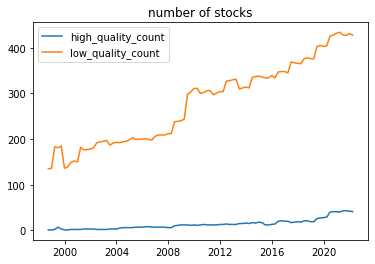

In [113]:
low_avg_count = quality_all[quality_all["10y_ind"]
                            == 0].groupby("Data Date").count()["Ticker"]
high_avg_count = quality_all[quality_all["10y_ind"] == 1].groupby("Data Date").count()[
    "Ticker"]

avg_ret = pd.merge(high_avg_count, low_avg_count,
                   left_index=True, right_index=True)
avg_ret.columns = ["high_quality_count", "low_quality_count"]
plt.plot(avg_ret)
plt.legend(avg_ret.columns)
plt.title("number of stocks")
plt.savefig("../plot/avg_ret.png")

In [115]:
low_avg_ret = quality_all[quality_all["10y_ind"] == 0].groupby("Data Date").mean()[
    "q_ret"]
high_avg_ret = quality_all[quality_all["10y_ind"] == 1].groupby("Data Date").mean()[
    "q_ret"]

avg_ret = pd.merge(high_avg_ret, low_avg_ret,
                   left_index=True, right_index=True)
avg_ret.columns = ["high_quality_avg_ret", "low_quality_avg_ret"]
ave_ret_cum = (avg_ret + 1).cumprod()
ave_ret_cum.columns = ["high_quality_cumprod", "low_quality_cumprod"]
avg_ret_all = pd.merge(avg_ret, ave_ret_cum, left_index=True, right_index=True)
avg_ret_all.to_excel("../clean_data/avg_ret_all_1118.xlsx")

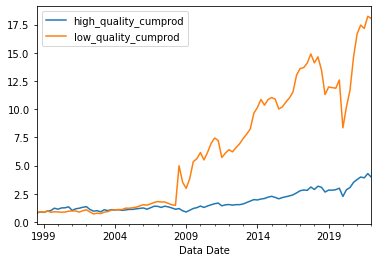

In [116]:
ave_ret_cum.plot()

In [82]:
avg_ret.merge(ave_ret_cum, left_index=True, right_index=True).to_excel("../clean_data/new_ret.xlsx")

In [38]:
ave_ret_cum

,high_quality_cumprod,low_quality_cumprod
Data Date,,
1997-09-30,1.645246,1.408991
1997-12-31,2.530409,1.820470
1998-03-31,4.156652,2.512880
1998-06-30,6.060904,2.917254
1998-09-30,6.647050,2.460528
...,...,...
2021-03-31,10988.873264,6212.820031
2021-06-30,15361.361636,10030.332466
2021-09-30,20132.250665,15411.302090


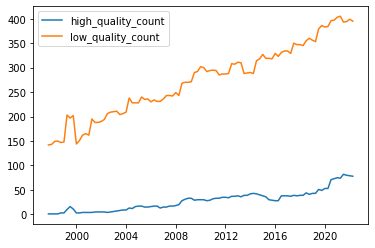

In [19]:
plt.plot(avg_ret)
plt.legend(avg_ret.columns)
plt.savefig("../plot/cumret.png")

In [68]:
def summary_stat(df, annual_factor, q=0.05):
    '''summary assets' mean return, voaltility(stdev) and sharpe ratio'''
    result = pd.DataFrame()
    result["mean"] = df.mean() * annual_factor
    result["volatility"] = df.std() * np.sqrt(annual_factor)
    result["Sharpe Ratio"] = result["mean"]/result["volatility"]

    result["VaR"] = df.quantile(q)
    return result

summary_stat(avg_ret, annual_factor=4)

,mean,volatility,Sharpe Ratio,VaR
high_quality_avg_ret,0.082174,0.212375,0.386928,-0.179299
low_quality_avg_ret,0.048728,0.223495,0.218028,-0.182003


In [ ]:
quality_all

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_ADJ,filtered,...,rf,coe,cost of equity,10y_avg,ind,close_date,Monthly Price Date,Ticker,q_ret_x,q_ret_y
0,9299,1987-12-31,1987,4.0,R,-0.154917,-0.004939,-0.020139,-0.154917,-0.154917,...,0.057656,0.136393,0.136393,0.155711,0,1987-12-31,1987-12-31,R,-0.273973,-0.273973
1,9299,1987-12-31,1987,4.0,R,-0.154917,-0.004939,-0.020139,-0.154917,-0.154917,...,0.057656,0.136393,0.136393,0.155711,0,1987-12-31,1987-12-31,R,-0.772727,-0.772727
2,10614,1987-12-31,1987,4.0,GL,0.225736,-0.024744,NaN,0.225736,0.225736,...,0.057656,0.117010,0.117010,0.138733,0,1987-12-31,1987-12-31,GL,-0.200000,-0.200000
3,9299,1988-03-31,1988,1.0,R,-0.044759,-0.005749,-0.023584,-0.044759,-0.044759,...,0.062058,0.135672,0.135672,0.154766,0,1988-03-31,1988-03-31,R,0.099057,0.099057
4,9299,1988-03-31,1988,1.0,R,-0.044759,-0.005749,-0.023584,-0.044759,-0.044759,...,0.062058,0.135672,0.135672,0.154766,0,1988-03-31,1988-03-31,R,-0.300000,-0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31958,199356,2021-12-31,2021,4.0,TRIP,0.031386,-0.052163,-0.151611,0.031386,0.031386,...,0.000507,0.083073,0.083073,0.054006,1,2021-12-31,2021-12-31,TRIP,-0.194682,-0.194682
31959,260774,2021-12-31,2021,4.0,CBRE,0.183715,0.049038,0.118106,0.183715,0.183715,...,0.000507,0.084284,0.084284,0.114787,0,2021-12-31,2021-12-31,CBRE,0.114523,0.114523
31960,315318,2021-12-31,2021,4.0,ESI,0.062421,-0.024881,-0.051197,0.062421,0.062421,...,0.000507,0.081897,0.081897,0.121450,0,2021-12-31,2021-12-31,ESI,0.119926,0.119926
31961,316056,2021-12-31,2021,4.0,ALLE,0.202411,-0.039820,-0.150675,0.202411,0.202411,...,0.000507,0.062225,0.062225,0.050331,0,2021-12-31,2021-12-31,ALLE,0.001967,0.001967


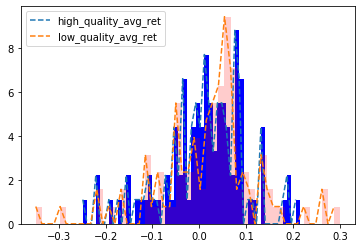

In [46]:
n1, bins1, patches1 = plt.hist(
    avg_ret.iloc[:, 0], bins=50, density=True, color='b', alpha=1)
n2, bins2, patches2 = plt.hist(
    avg_ret.iloc[:, 1], bins=50, density=True, color='r', alpha=0.2)

plt.plot(bins1[:-1], n1, '--')
plt.plot(bins2[:-1], n2, '--')
plt.legend(avg_ret.columns)

In [48]:
avg_ret.mean()/avg_ret.std()

high_quality_avg_ret    0.127573
low_quality_avg_ret     0.196831
dtype: float64

In [78]:
quality_all.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Ticker Symbol', 'FCFROIC', 'ROA', 'ROE', 'FCFROIC_ADJ', 'filtered',
       'avg_fcfroic', 'avg_fcfroic_ajd', 'beta', 'TMBIDYTM', 'rf', 'coe',
       'cost of equity', '10y_avg', '10y_ind', 'ind', 'close_date',
       'Monthly Price Date', 'Ticker', 'Monthly Price'],
      dtype='object')

In [79]:
high_q_group = quality_all[quality_all["10y_ind"] == 1].groupby("Fiscal Year")
low_q_group = quality_all[quality_all["10y_ind"] == 0].groupby("Fiscal Year")
high_dict = {}
for g in high_q_group:
    y = g[0]
    g = g[1]
    high_dict[y] = g["Ticker"].drop_duplicates()

In [45]:
close_price = close_price.drop_duplicates(
    subset=["Ticker", "Monthly Calendar Date"])
close_price.sort_values(by=["Ticker", "Monthly Calendar Date"], inplace=True)

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [46]:
close_price

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return,q_pre_p,q_ret,1y_rollingret,3y_rollingret,5y_rollingret
8114,A,1961-01-31,49.125,1961-01-31,43.500,0.129310,23.375,1.101604,0.550685,0.914537,1.138674
8115,A,1961-02-28,54.125,1961-02-28,49.125,0.101781,23.500,1.303191,0.748561,0.909014,1.407833
8116,A,1961-03-30,54.000,1961-03-30,54.125,0.007103,27.000,1.000000,0.672378,0.882796,1.424935
8117,A,1961-04-28,60.625,1961-04-28,54.000,0.122685,49.125,0.234097,0.756065,1.173753,1.532501
8118,A,1961-05-31,62.375,1961-05-31,60.625,0.037113,54.125,0.152425,0.734430,1.346748,1.578886
...,...,...,...,...,...,...,...,...,...,...,...
58488,ZU,2015-05-29,13.225,2015-05-29,12.465,0.060971,14.010,-0.056031,-0.619205,-0.851835,-0.623584
58489,ZU,2015-06-30,13.040,2015-06-30,13.225,-0.013989,12.990,0.003849,-0.681563,-0.858546,-0.616357
58490,ZU,2015-07-31,13.210,2015-07-31,13.040,0.013037,12.465,0.059767,-0.618429,-0.853566,-0.594835
58491,ZU,2015-08-31,17.750,2015-08-31,13.210,0.343679,13.225,0.342155,-0.458841,-0.800923,-0.550232


,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret,year
Monthly Price Date,,,,,,,
1961-01-31,1961-01-31,0.129310,A,NaN,NaN,NaN,1961
1961-02-28,1961-02-28,0.101781,A,NaN,NaN,NaN,1961
1961-03-30,1961-03-30,0.007103,A,NaN,NaN,NaN,1961
1961-04-28,1961-04-28,0.122685,A,NaN,NaN,NaN,1961
1961-05-31,1961-05-31,0.037113,A,NaN,NaN,NaN,1961
...,...,...,...,...,...,...,...
2015-05-29,2015-05-29,0.060971,ZU,-0.619205,NaN,NaN,2015
2015-06-30,2015-06-30,-0.013989,ZU,-0.681563,NaN,NaN,2015
2015-07-31,2015-07-31,0.013037,ZU,-0.618429,NaN,NaN,2015


In [125]:
close_price_u = rolling_ret
quality_all = pd.merge(quality, close_price_u, left_on=["close_date", "Ticker Symbol"],
                       right_on=["Monthly Price Date", "Ticker"], how="inner")
quality_all

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_,FCFROIC_ADJ,...,10y_avg,10y_ind,ind,close_date,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret
0,2002,1983-12-31,1983,4.0,BPOP,NaN,0.000342,0.005496,NaN,0.005496,...,0.116880,0,0,1984-03-30,1984-03-30,0.000000,BPOP,0.323420,1.042762,1.268633
1,2005,1983-12-31,1983,4.0,BOH,NaN,0.000061,0.000985,NaN,0.000985,...,0.079986,0,0,1984-03-30,1984-03-30,-0.011628,BOH,-0.052013,0.328124,1.074128
2,2558,1983-12-31,1983,4.0,CNA,NaN,0.004512,0.035035,NaN,0.035035,...,0.094355,0,0,1984-03-30,1984-03-30,0.312500,CNA,0.657895,0.953488,1.230088
3,3231,1983-12-31,1983,4.0,CMA,NaN,-0.000231,-0.004312,NaN,-0.004312,...,0.105442,0,0,1984-03-30,1984-03-30,0.077183,CMA,0.230692,0.768985,0.809207
4,3643,1983-12-31,1983,4.0,CFR,NaN,-0.009307,-0.168009,NaN,-0.168009,...,0.087668,0,0,1984-03-30,1984-03-30,0.047619,CFR,0.646145,0.816837,2.409308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30114,192255,2022-03-31,2022,1.0,ACHC,0.006239,-0.001966,-0.003708,NaN,0.006239,...,0.066162,0,0,2022-03-31,2022-03-31,0.155528,ACHC,0.146832,1.235756,0.502982
30115,199356,2022-03-31,2022,1.0,TRIP,0.042291,-0.002145,-0.006427,NaN,0.042291,...,0.115826,0,0,2022-03-31,2022-03-31,0.066038,TRIP,-0.495817,-0.407879,-0.294147
30116,260774,2022-03-31,2022,1.0,CBRE,-0.036166,-0.013869,-0.032153,NaN,-0.036166,...,0.139234,0,0,2022-03-31,2022-03-31,-0.055034,CBRE,0.156870,0.850758,1.630641
30117,315318,2022-03-31,2022,1.0,ESI,-0.003415,0.010168,0.020820,NaN,-0.003415,...,0.130204,0,0,2022-03-31,2022-03-31,-0.109032,ESI,0.211757,1.208144,0.712923


In [126]:
quality_all.to_excel("../clean_data/quality_n_1118.xlsx")

In [127]:
high_q = quality_all[quality_all["10y_ind"] == 1]
low_q = quality_all[quality_all["10y_ind"] == 0]
high_q.to_excel("../clean_data/highq_bucket_1118.xlsx")
low_q.to_excel("../clean_data/lowq_bucket_1118.xlsx")

In [128]:
high_q.drop_duplicates(subset=["Fiscal Year", "Ticker"], keep="last", inplace=True)
low_q.drop_duplicates(subset=["Fiscal Year", "Ticker"], keep="last", inplace=True)

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [130]:
rolling_ret.index = rolling_ret["Monthly Price Date"]
rolling_ret["year"] = [str(date.year) for date in rolling_ret["Monthly Price Date"]]

In [131]:
rolling_ret

,Monthly Price Date,Monthly Total Return,Ticker,1y_rollingret,3y_rollingret,5y_rollingret,year
Monthly Price Date,,,,,,,
1961-01-31,1961-01-31,0.129310,A,NaN,NaN,NaN,1961
1961-02-28,1961-02-28,0.101781,A,NaN,NaN,NaN,1961
1961-03-30,1961-03-30,0.007103,A,NaN,NaN,NaN,1961
1961-04-28,1961-04-28,0.122685,A,NaN,NaN,NaN,1961
1961-05-31,1961-05-31,0.037113,A,NaN,NaN,NaN,1961
...,...,...,...,...,...,...,...
2015-05-29,2015-05-29,0.060971,ZU,-0.619205,NaN,NaN,2015
2015-06-30,2015-06-30,-0.013989,ZU,-0.681563,NaN,NaN,2015
2015-07-31,2015-07-31,0.013037,ZU,-0.618429,NaN,NaN,2015


In [132]:
high_q_group = high_q.groupby("Fiscal Year")
ls = []
for g in high_q_group:
    year = g[0]
    ticker = g[1]["Ticker Symbol"].drop_duplicates().values
    roll_ret = rolling_ret[(rolling_ret["year"] == str(year)) & (rolling_ret["Ticker"].isin(ticker))].groupby("Ticker").mean()
    roll_ret["Ticker"] = roll_ret.index
    roll_ret["Year"] = year
    ls.append(roll_ret)
high_ret_n = pd.concat(ls, ignore_index=True)

In [133]:
high_ret_n.to_excel("../clean_data/highq_bucket_rolling_is_1118.xlsx")

In [134]:
high_ret_n

,Monthly Total Return,1y_rollingret,3y_rollingret,5y_rollingret,Ticker,Year
0,0.013877,0.283246,0.933294,1.519908,WWY,1998
1,0.087880,0.922884,1.545036,0.739407,AAPL,1999
2,0.009907,-0.382179,0.110223,4.345759,CDNS,1999
3,-0.007178,-0.018728,-0.039803,0.158105,IFF,1999
4,0.006695,-0.074129,0.313583,0.520265,LANC,1999
...,...,...,...,...,...,...
419,-0.024506,0.038593,0.183675,0.142766,TPR,2022
420,-0.009987,-0.088829,1.175938,4.354327,UI,2022
421,-0.039797,0.113266,0.236238,1.617638,VRSN,2022
422,-0.057152,0.152743,0.308407,1.096407,WAT,2022


In [135]:
low_q_group = low_q.groupby("Fiscal Year")
ls = []
for g in low_q_group:
    year = g[0]
    ticker = g[1]["Ticker Symbol"].values
    high_ticker = set(high_ret_n[high_ret_n["Year"] == year].Ticker.values)
    ticker = list(set(ticker) - high_ticker)
    roll_ret = rolling_ret[(rolling_ret["year"] == str(year)) & (
        rolling_ret["Ticker"].isin(ticker))].groupby("Ticker").mean()
    roll_ret["Ticker"] = roll_ret.index
    roll_ret["Year"] = year
    ls.append(roll_ret)
low_ret_n = pd.concat(ls, ignore_index=True)
low_ret_n

,Monthly Total Return,1y_rollingret,3y_rollingret,5y_rollingret,Ticker,Year
0,0.034196,0.379791,1.284378,3.251797,AFG,1983
1,0.016233,0.395971,0.862873,1.569765,BOH,1983
2,0.024776,0.814696,0.999936,1.344061,BPOP,1983
3,0.034503,0.279181,0.935553,1.627161,CFR,1983
4,0.028710,0.403572,0.650568,0.662268,CMA,1983
...,...,...,...,...,...,...
8456,-0.039189,-0.063006,0.215658,-0.106157,XRAY,2022
8457,-0.032685,-0.090961,-0.234674,-0.137924,XRX,2022
8458,0.090367,0.182586,0.178523,0.206928,Y,2022
8459,0.010159,-0.196088,0.079685,0.106347,ZBH,2022


In [136]:
low_ret_n.to_excel("../clean_data/lowq_bucket_rolling_is_1118.xlsx")

In [137]:
high_ret_n.groupby("Year").mean().to_excel("../clean_data/high_rolling_is_1118.xlsx")

In [138]:
low_ret_n.groupby("Year").mean().to_excel("../clean_data/low_rolling_is_1118.xlsx")

In [195]:
high_q_mean = high_ret_n.groupby("Year").mean()
low_q_mean = low_ret_n.groupby("Year").mean()
high_q_mean.to_excel("../clean_data/high_ret_is.xlsx")

In [196]:
low_q_mean.to_excel("../clean_data/low_ret_is.xlsx")